## EDA

Columns:

`Education` : The educational qualifications of employees, including degree, institution, and field of study.

`Joining Year` : The year each employee joined the company, indicating their length of service.

`City` : The location or city where each employee is based or works.

`Payment Tier` : Categorization of employees into different salary tiers. (數字越小層級越高)

`Age` : The age of each employee, providing demographic insights.

`Gender` : Gender identity of employees, promoting diversity analysis.

`Ever Benched` : Indicates if an employee has ever been temporarily without assigned work.

`Experience in Current Domain` : The number of years of experience employees have in their current field.

`Leave or Not` : a target column 預測是否離職

In [2]:
#Data Handling
import numpy as np 
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statistics
from scipy import stats

In [3]:
data = pd.read_csv('Employee.csv')
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [5]:
data['LeaveOrNot'] = data['LeaveOrNot'].astype(object)
data['PaymentTier'] = data['PaymentTier'].astype(object)

In [6]:
data.shape

(4653, 9)

In [7]:
import os
pic_path = './picture/'

In [8]:
tmp  = list(data.dtypes != np.int64)
cols = data.columns[tmp].tolist()
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'LeaveOrNot']


In [9]:
tmp  = list(data.dtypes == np.int64)
num_cols = data.columns[tmp].tolist()
print(num_cols)

['JoiningYear', 'Age', 'ExperienceInCurrentDomain']


In [10]:
def plot_hist(name):
    sns.countplot(x = name, data = data)
    plt.ylabel('Total')
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

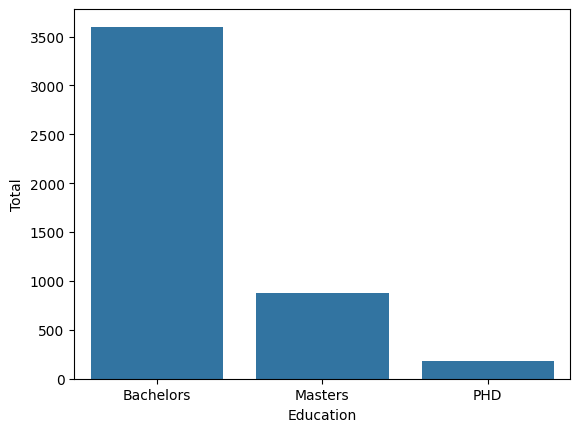

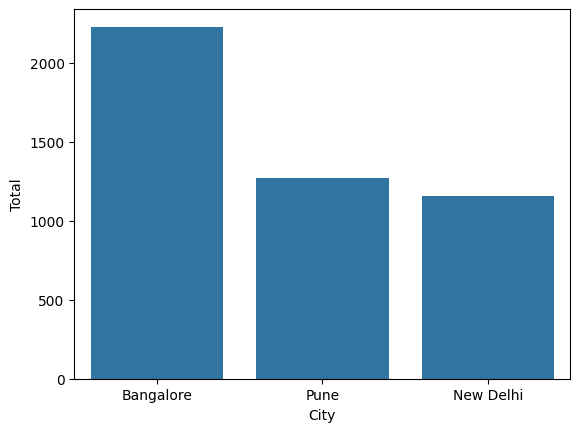

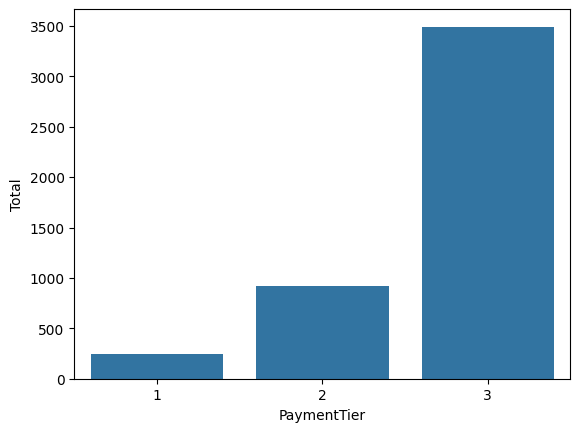

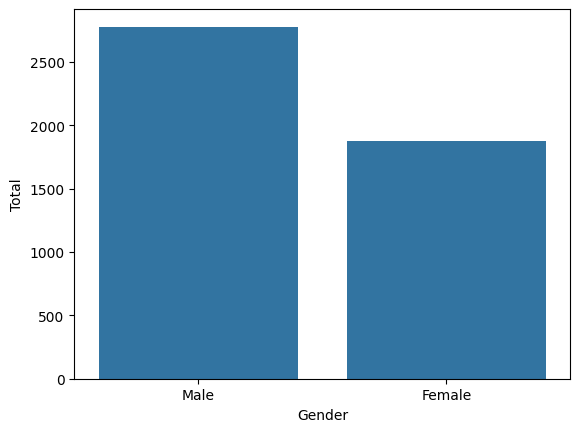

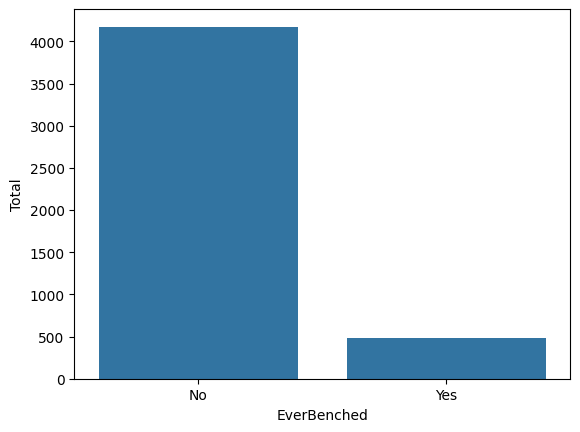

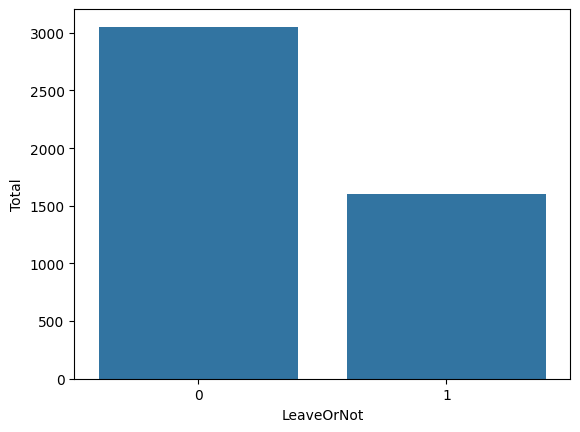

<Figure size 640x480 with 0 Axes>

In [11]:
tmp = list(map(plot_hist, cols))

In [12]:
def plot_box(name):
    sns.boxplot(data = data, x = name)
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

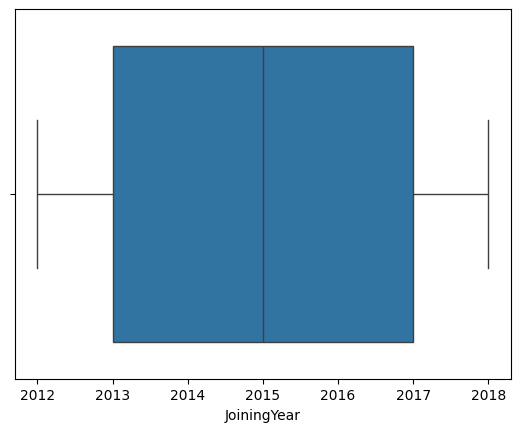

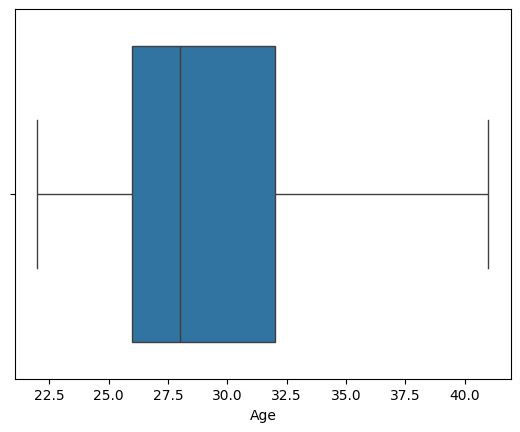

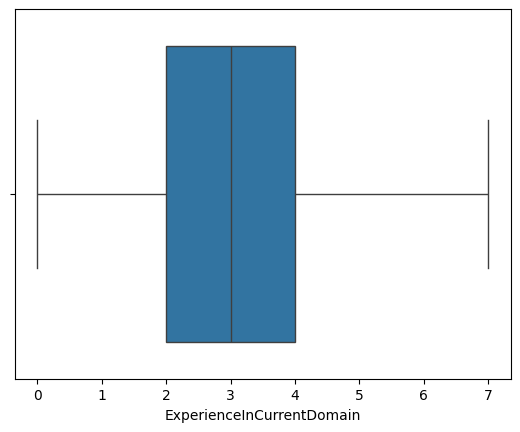

<Figure size 640x480 with 0 Axes>

In [13]:
tmp = list(map(plot_box, num_cols))

In [14]:
cols.remove('LeaveOrNot')
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']


In [15]:
def plot_bi_hist(name):
    sns.countplot(x = name, data = data, hue = 'LeaveOrNot')
    plt.ylabel('Total')
    plt.xlabel(name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

In [16]:
def plot_bi_box(name):
    sns.boxplot(data = data, x = 'LeaveOrNot', y = name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

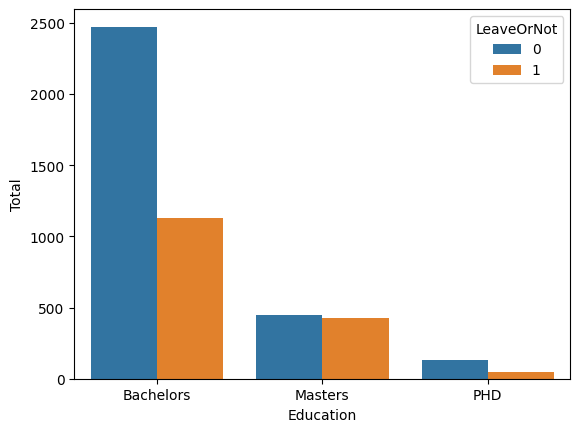

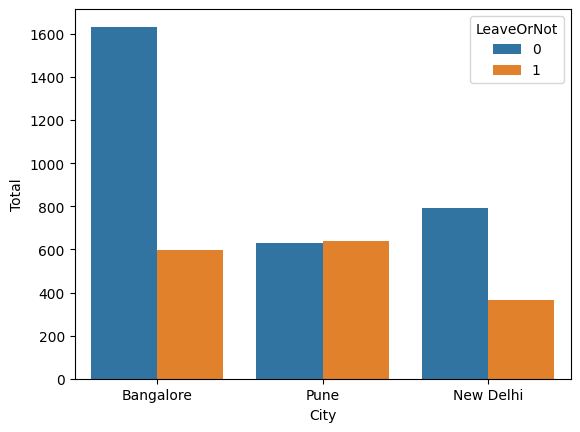

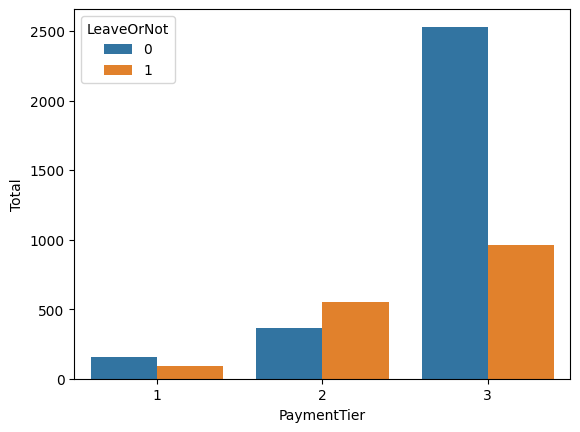

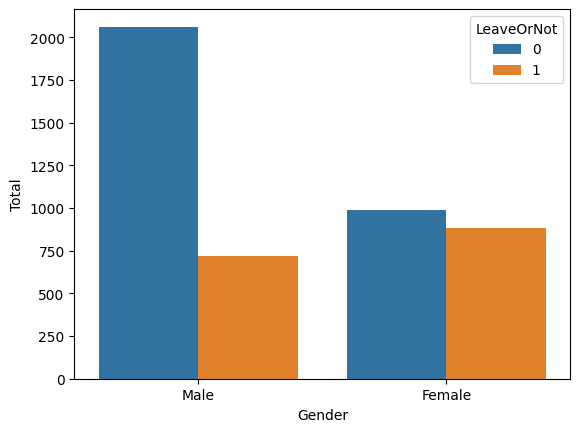

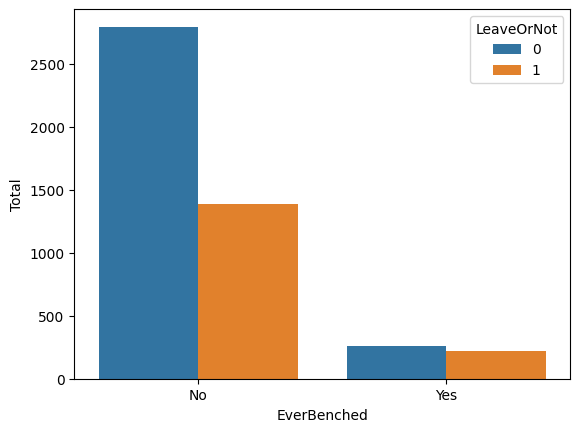

<Figure size 640x480 with 0 Axes>

In [17]:
tmp = list(map(plot_bi_hist, cols))

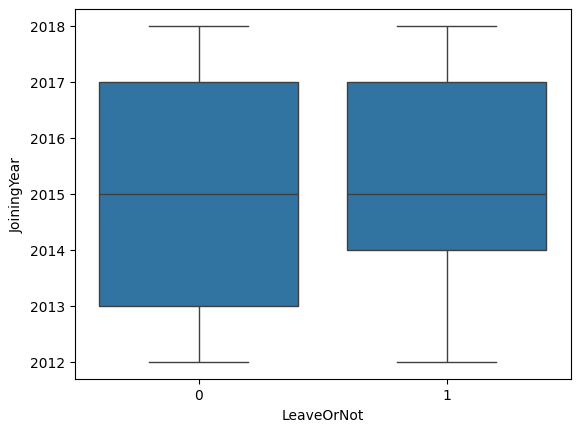

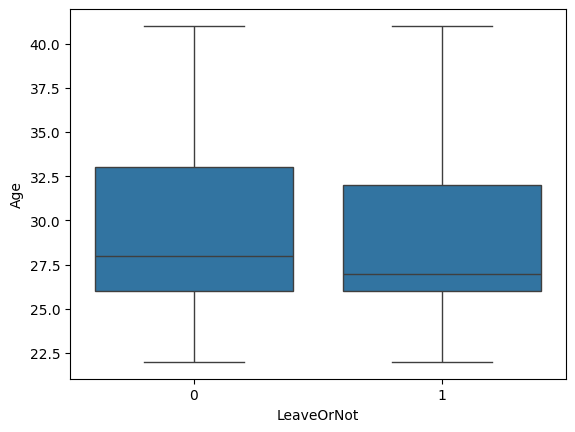

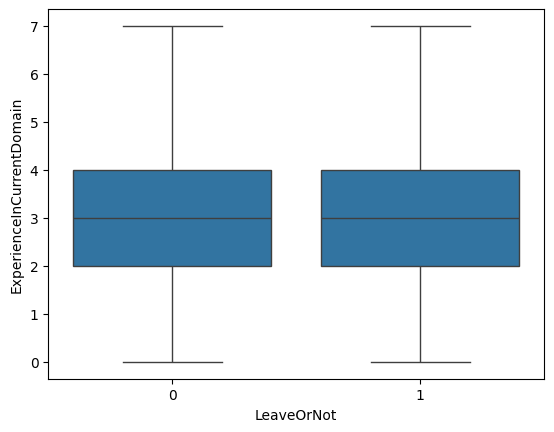

<Figure size 640x480 with 0 Axes>

In [18]:
tmp = list(map(plot_bi_box, num_cols))

In [19]:
def stats_test(col):
  if data[col].dtype == np.int64 or data[col].dtype == np.float64:
    tmp0 = data.loc[data['LeaveOrNot'] == 0, col].values
    tmp1 = data.loc[data['LeaveOrNot'] == 1, col].values

    result = stats.ttest_ind(tmp0, tmp1)[0:2]

  else:
    contingency_table = data.pivot_table(index = [col], columns = 'LeaveOrNot', values = 'Age', aggfunc = 'count')
    contingency_table = contingency_table.fillna(0)
    contingency_table = contingency_table.values

    result = stats.chi2_contingency(contingency_table, correction = False)[0:2]

  return result

### 檢定結果

In [20]:
all_cols = data.columns[:-1].tolist()
results = {c: stats_test(c) for c in all_cols}
print(results)

{'Education': (101.83014138498626, 7.724417739147332e-23), 'JoiningYear': (-12.601776125876363, 7.90161666436133e-36), 'City': (206.15885400194648, 1.7106992135618012e-45), 'PaymentTier': (338.6305486794045, 2.9329904732261673e-74), 'Age': (3.491261554959713, 0.0004852123420648862), 'Gender': (226.64164837884488, 3.219334068915125e-51), 'EverBenched': (28.627472496502868, 8.772866504669789e-08), 'ExperienceInCurrentDomain': (2.081296101564669, 0.03746138354045199)}


全部都顯著，所以就先全部餵進模型。

In [21]:
# 固定亂數種子
seed = 1126

In [22]:
x = data.drop(['LeaveOrNot'], axis=1)
y = data['LeaveOrNot'].astype(np.int64)

In [23]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed, stratify = y)

用簡單的leave-one-out target encoding encode categorical data

In [25]:
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [26]:
encoder = ce.LeaveOneOutEncoder(cols = cols, sigma = 0.05)
encoder.fit(x_train, y_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [27]:
x_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
939,0.30982,2017,0.496538,0.271813,27,0.256901,0.33094,5
3326,0.30982,2017,0.496538,0.599185,33,0.476287,0.33094,2
3113,0.30982,2014,0.269016,0.271813,40,0.476287,0.33094,0
69,0.50142,2017,0.269016,0.271813,40,0.476287,0.33094,2
3546,0.50142,2018,0.496538,0.271813,31,0.256901,0.33094,2


將數值資料standardize

In [28]:
from sklearn.preprocessing import StandardScaler

std_encoder = StandardScaler()
x_train = std_encoder.fit_transform(x_train)
x_test = std_encoder.transform(x_test)

In [29]:
x_train[0:3]

array([[-0.44294974,  1.03450786,  1.59624031, -0.55293904, -0.49837554,
        -0.81065918, -0.33720078,  1.34599141],
       [-0.44294974,  1.03450786,  1.59624031,  1.95811516,  0.74294975,
         1.23356403, -0.33720078, -0.59028018],
       [-0.44294974, -0.57767843, -0.7831341 , -0.55293904,  2.19116258,
         1.23356403, -0.33720078, -1.88112791]])

In [30]:
print(x_train.shape)
print(x_test.shape)

(3722, 8)
(931, 8)


In [31]:
x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_train_copy.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,-0.442950,1.034508,1.596240,-0.552939,-0.498376,-0.810659,-0.337201,1.345991
1,-0.442950,1.034508,1.596240,1.958115,0.742950,1.233564,-0.337201,-0.590280
2,-0.442950,-0.577678,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-1.881128
3,2.047278,1.034508,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-0.590280
4,2.047278,1.571903,1.596240,-0.552939,0.329175,-0.810659,-0.337201,-0.590280


<Axes: >

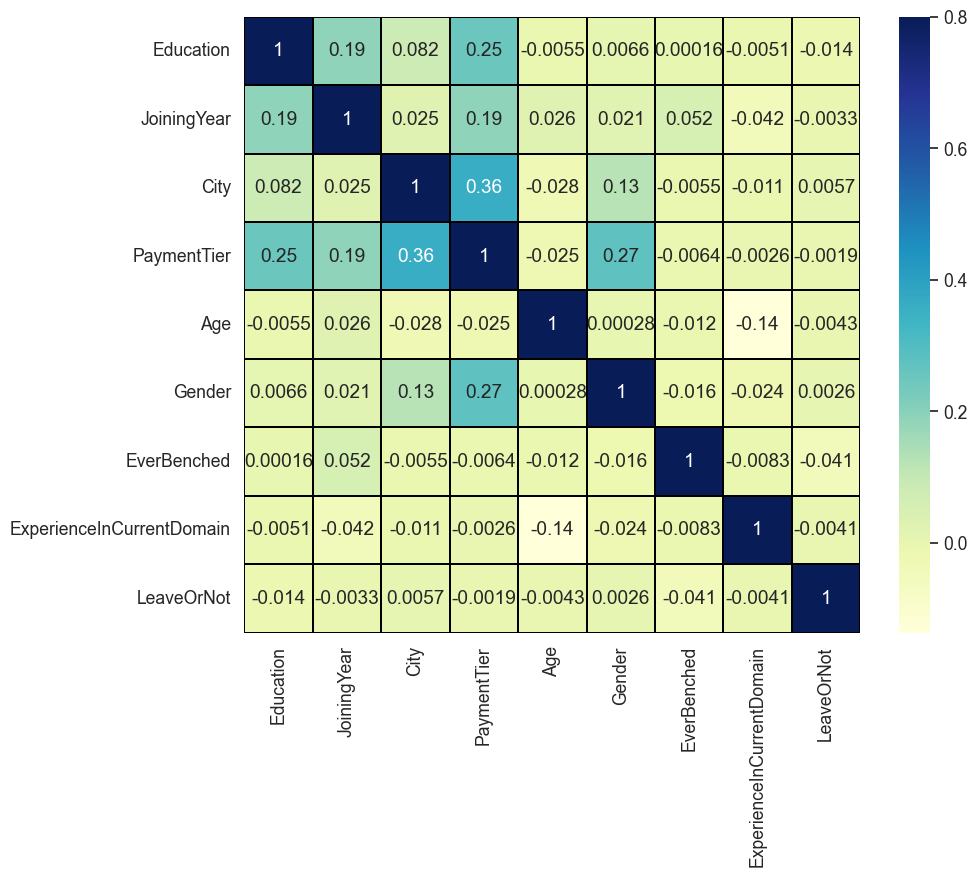

In [32]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (10, 8))
sns.heatmap(pd.concat([x_train_copy, y_train], axis = 1).corr(), vmax = 0.8, linewidths = 0.01, square = True, 
            annot = True, cmap='YlGnBu',
linecolor = 'black')

用border line smote去做upsampling

In [33]:
from imblearn.over_sampling import BorderlineSMOTE

smote_enn = BorderlineSMOTE(random_state = seed)
x_train_resampled, y_train_resampled = smote_enn.fit_resample(x_train, y_train)

直接補到0 1同樣數量

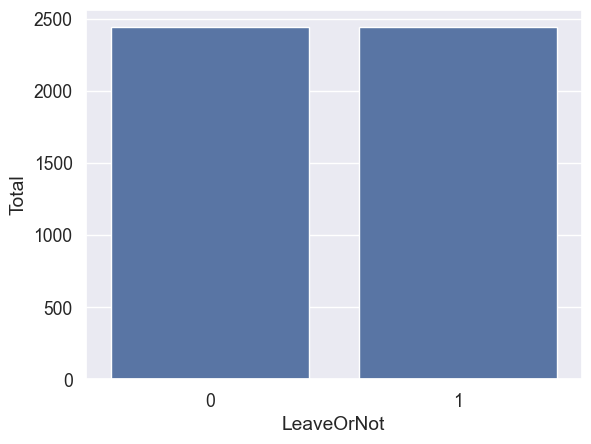

In [34]:
sns.countplot(x = y_train_resampled)
plt.ylabel('Total')
plt.xlabel('LeaveOrNot')
plt.show()

In [35]:
y_train_resampled.shape

(4884,)

## SVM, MLP, XGBoost

In [36]:
## 定義評估函數
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from pprint import pprint

def eval_pipeline(y_test, y_pred, y_pred_prob):
    report = classification_report(y_test, y_pred, output_dict = True).get('1')
    auc = roc_auc_score(y_test, y_pred_prob)
    report['auc'] = auc
    pprint(report)
    return report


def plot_confusion_matrix(y_test, y_pred, title = None):
    title = 'Confusion Matrix ' + title if title else 'Confusion Matrix'
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_roc_curve(y_test, y_pred, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'ROC Curve' + title if title else 'ROC Curve'
    plt.title('ROC Curve')
    plt.show()

### SVM

In [37]:
from sklearn import svm

def svm_model(kernel, x_train, y_train, x_test, y_test,):
    print("Kernel: ", kernel)
    clf_svm = svm.SVC(random_state = seed, kernel=kernel, probability=True)
    clf_svm.fit(x_train, y_train)

    y_pred = clf_svm.predict(x_test)
    y_pred_prob = clf_svm.predict_proba(x_test)[:, 1]
    report = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred, kernel)
    return report

Kernel:  linear
{'auc': 0.7073291734860884,
 'f1-score': 0.5687074829931973,
 'precision': 0.5036144578313253,
 'recall': 0.653125,
 'support': 320.0}


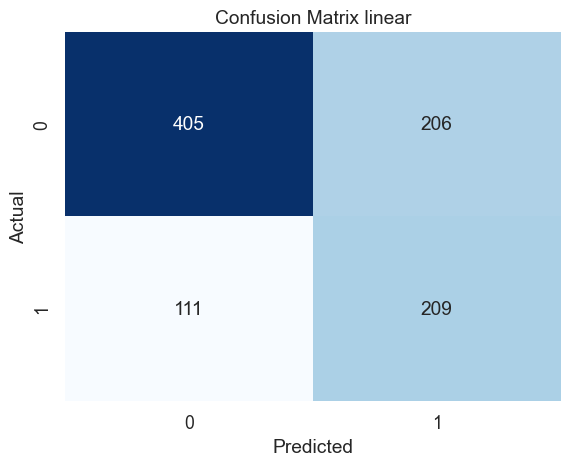

Kernel:  poly
{'auc': 0.8151928191489362,
 'f1-score': 0.6945736434108527,
 'precision': 0.6892307692307692,
 'recall': 0.7,
 'support': 320.0}


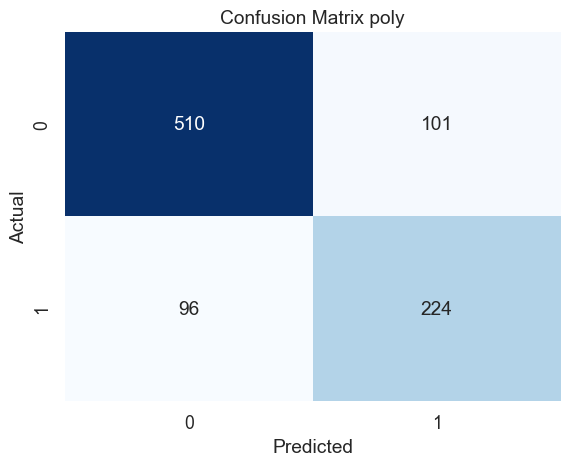

Kernel:  rbf
{'auc': 0.8465604541734861,
 'f1-score': 0.7275449101796407,
 'precision': 0.6982758620689655,
 'recall': 0.759375,
 'support': 320.0}


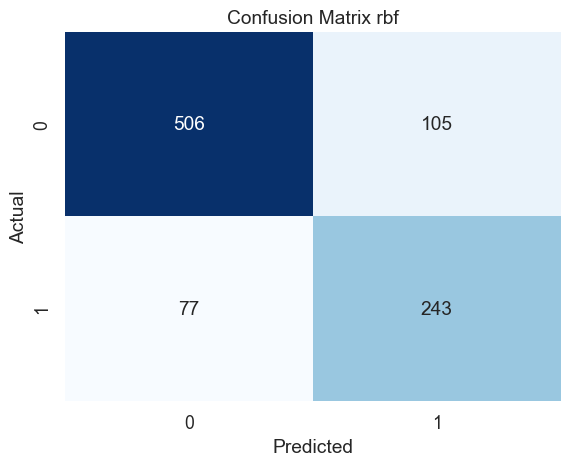

Kernel:  sigmoid
{'auc': 0.3923000204582652,
 'f1-score': 0.521181001283697,
 'precision': 0.4422657952069717,
 'recall': 0.634375,
 'support': 320.0}


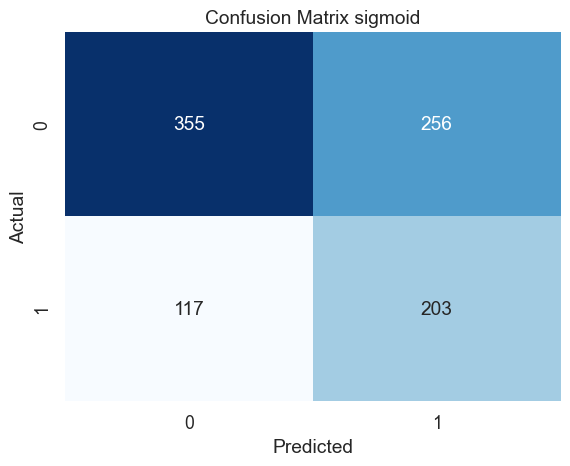



BEST ONE:  {'precision': 0.6982758620689655, 'recall': 0.759375, 'f1-score': 0.7275449101796407, 'support': 320.0, 'auc': 0.8465604541734861}


In [38]:
# 根據情況調整參數
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm_repo = None

best_svm_model = None
# SMOTE後的資料
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
    else:
        cur_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
print("\n\nBEST ONE: ", best_svm_repo)

使用 Radial Basis Function (RBF) 的效果最佳。

Kernel:  linear
{'auc': 0.6768233428805237,
 'f1-score': 0.4342629482071713,
 'precision': 0.5989010989010989,
 'recall': 0.340625,
 'support': 320.0}


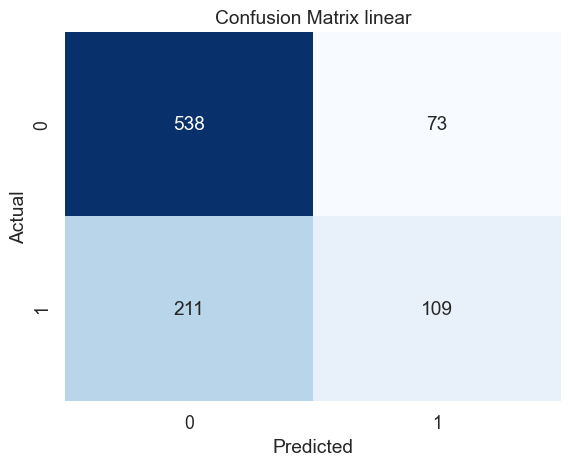



BEST ONE:  {'precision': 0.6982758620689655, 'recall': 0.759375, 'f1-score': 0.7275449101796407, 'support': 320.0, 'auc': 0.8465604541734861}
Kernel:  poly
{'auc': 0.8219235883797054,
 'f1-score': 0.7140186915887851,
 'precision': 0.8883720930232558,
 'recall': 0.596875,
 'support': 320.0}


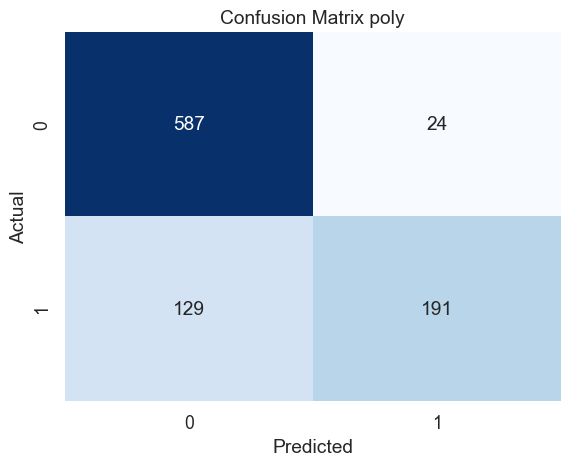



BEST ONE:  {'precision': 0.6982758620689655, 'recall': 0.759375, 'f1-score': 0.7275449101796407, 'support': 320.0, 'auc': 0.8465604541734861}
Kernel:  rbf
{'auc': 0.8455068535188216,
 'f1-score': 0.7422303473491774,
 'precision': 0.8942731277533039,
 'recall': 0.634375,
 'support': 320.0}


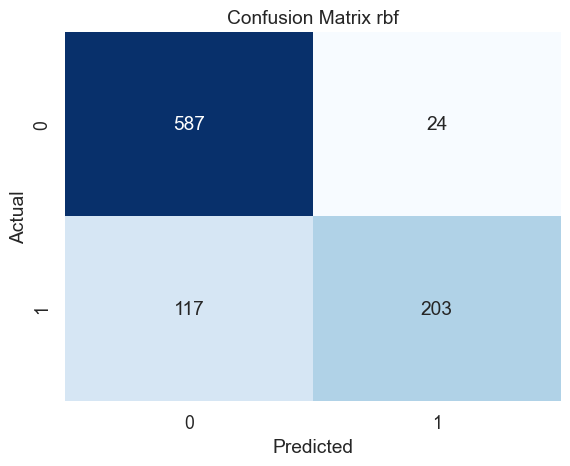



BEST ONE:  {'precision': 0.6982758620689655, 'recall': 0.759375, 'f1-score': 0.7275449101796407, 'support': 320.0, 'auc': 0.8465604541734861}
Kernel:  sigmoid
{'auc': 0.6128247749590834,
 'f1-score': 0.2685624012638231,
 'precision': 0.2715654952076677,
 'recall': 0.265625,
 'support': 320.0}


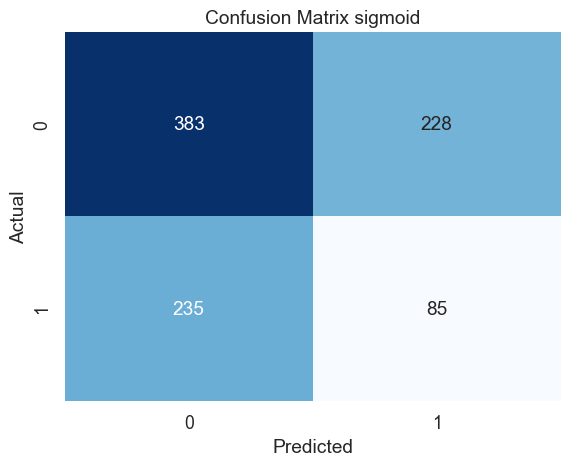



BEST ONE:  {'precision': 0.6982758620689655, 'recall': 0.759375, 'f1-score': 0.7275449101796407, 'support': 320.0, 'auc': 0.8465604541734861}


In [39]:
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
        
    else:
        cur_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
    print("\n\nBEST ONE: ", best_svm_repo)

### MLP

In [40]:
from sklearn.neural_network import MLPClassifier

def mlp_model(x_train, y_train, x_test, y_test, max_iter=100):
    clf_mlp = MLPClassifier(random_state = seed, max_iter=max_iter, momentum=0.99, early_stopping=True, learning_rate_init=0.001)
    clf_mlp.fit(x_train, y_train)

    y_pred = clf_mlp.predict(x_test)
    y_pred_prob = clf_mlp.predict_proba(x_test)[:, 1]
    repo = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)
    return repo


{'auc': 0.8345872545008184,
 'f1-score': 0.6910112359550562,
 'precision': 0.6275510204081632,
 'recall': 0.76875,
 'support': 320.0}


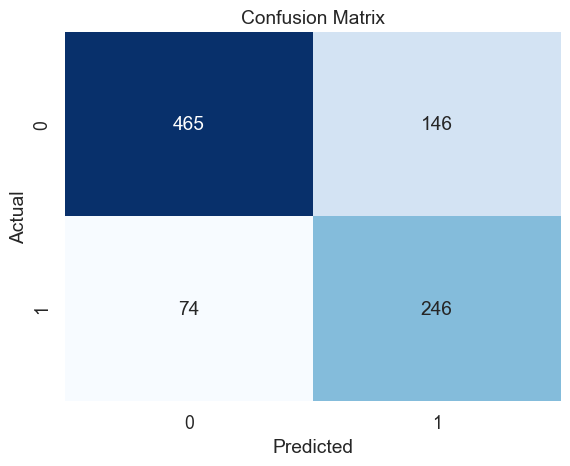

{'auc': 0.8345872545008184,
 'f1-score': 0.6910112359550562,
 'precision': 0.6275510204081632,
 'recall': 0.76875,
 'support': 320.0}


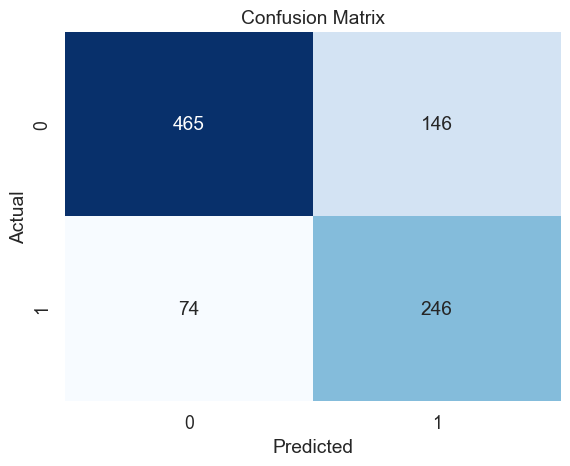

{'auc': 0.8345872545008184,
 'f1-score': 0.6910112359550562,
 'precision': 0.6275510204081632,
 'recall': 0.76875,
 'support': 320.0}


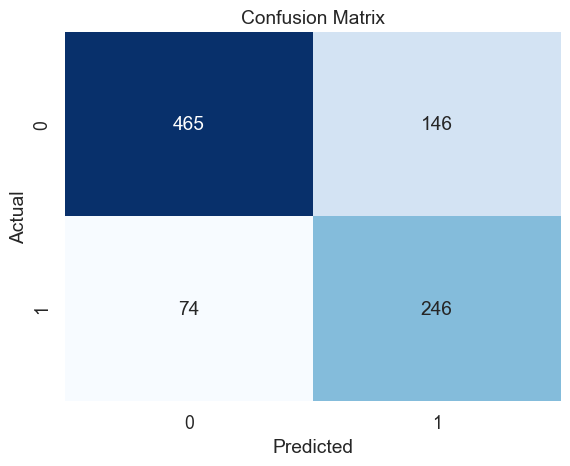



BEST ONE:  {'precision': 0.6275510204081632, 'recall': 0.76875, 'f1-score': 0.6910112359550562, 'support': 320.0, 'auc': 0.8345872545008184}


In [41]:
# SMOTE
best_mlp_repo = None
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
print("\n\nBEST ONE: ", best_mlp_repo)

{'auc': 0.8380268003273321,
 'f1-score': 0.7185840707964601,
 'precision': 0.8285714285714286,
 'recall': 0.634375,
 'support': 320.0}


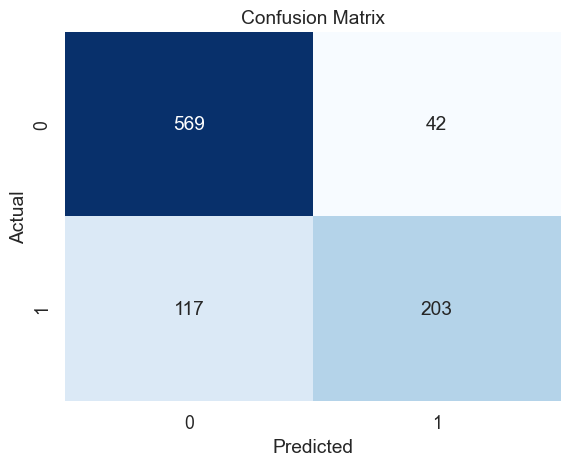

{'auc': 0.8380268003273321,
 'f1-score': 0.7185840707964601,
 'precision': 0.8285714285714286,
 'recall': 0.634375,
 'support': 320.0}


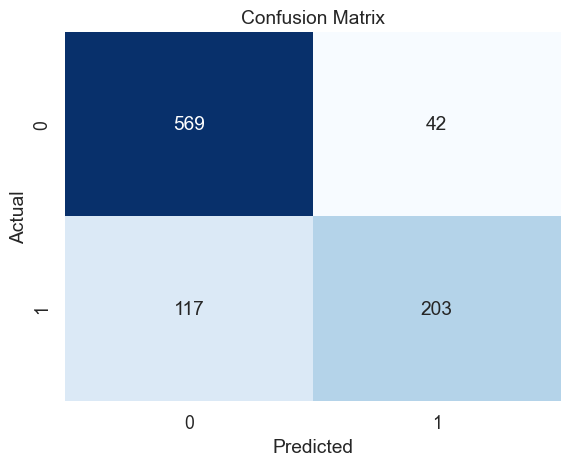

{'auc': 0.8380268003273321,
 'f1-score': 0.7185840707964601,
 'precision': 0.8285714285714286,
 'recall': 0.634375,
 'support': 320.0}


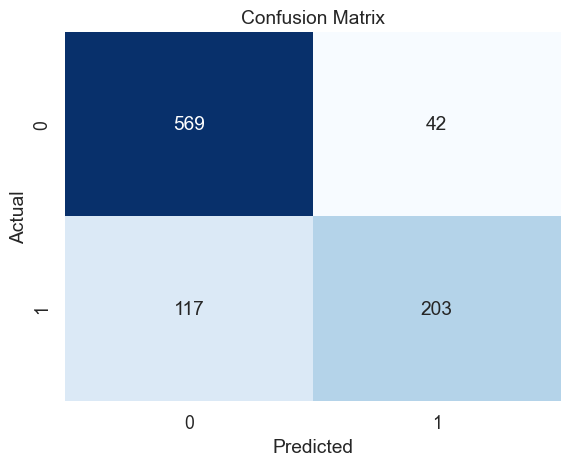



BEST ONE:  {'precision': 0.8285714285714286, 'recall': 0.634375, 'f1-score': 0.7185840707964601, 'support': 320.0, 'auc': 0.8380268003273321}


In [42]:
# 未使用SMOTE
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
print("\n\nBEST ONE: ", best_mlp_repo)

### XGBoost

In [44]:
# XGBoost
from xgboost import XGBClassifier

def xgb_model(x_train, y_train, x_test, y_test):
    clf_xgb = XGBClassifier(random_state = seed)
    clf_xgb.fit(x_train, y_train)

    y_pred = clf_xgb.predict(x_test)
    y_pred_prob = clf_xgb.predict_proba(x_test)[:, 1]
    report = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)
    return report, clf_xgb
    

{'auc': 0.8646762479541735,
 'f1-score': 0.743421052631579,
 'precision': 0.7847222222222222,
 'recall': 0.70625,
 'support': 320.0}


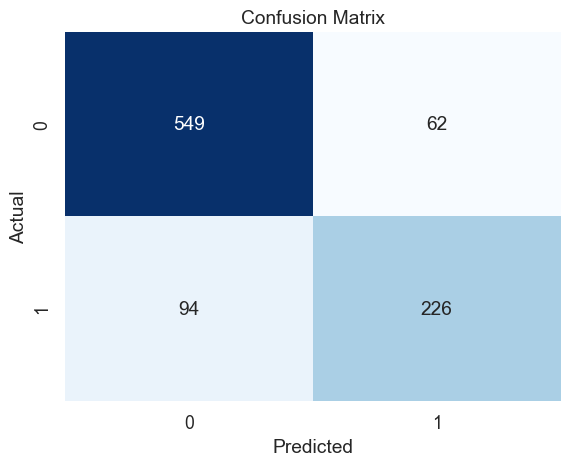

In [45]:
best_xgb_repo, clf_xgb = xgb_model(x_train_resampled, y_train_resampled, x_test, y_test)

In [46]:
model_reports = {
    'svm': best_svm_repo,
    'mlp': best_mlp_repo,
    'xgb': best_xgb_repo
}
pprint(model_reports)

{'mlp': {'auc': 0.8380268003273321,
         'f1-score': 0.7185840707964601,
         'precision': 0.8285714285714286,
         'recall': 0.634375,
         'support': 320.0},
 'svm': {'auc': 0.8465604541734861,
         'f1-score': 0.7275449101796407,
         'precision': 0.6982758620689655,
         'recall': 0.759375,
         'support': 320.0},
 'xgb': {'auc': 0.8646762479541735,
         'f1-score': 0.743421052631579,
         'precision': 0.7847222222222222,
         'recall': 0.70625,
         'support': 320.0}}


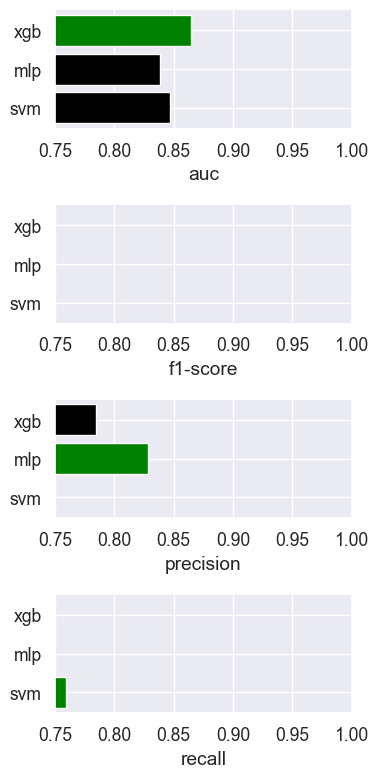

In [47]:
# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(4,8))

metrics = ['auc', 'f1-score', 'precision', 'recall']

for i, metric in enumerate(metrics):
    values = [model[metric] for model in model_reports.values()]
    max_value = max(values)
    bar_colors = ['green' if value == max_value else 'black' for value in values]
    axs[i].barh(list(model_reports.keys()), values, color=bar_colors)
    axs[i].set_xlabel(metric)
    axs[i].set_xlim([0.75, 1])  # Adjust this as needed

plt.tight_layout()
plt.show()

## Logistic Regression, Decision Tree, Knn

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
def Grid_Search(clf, param_grid, x_train, y_train):
    # 使用GridSearchCV進行交叉驗證
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(x_train, y_train)

    # 獲取結果
    print(grid_search.best_params_)

### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(random_state = seed)

def call_model(clf, x_train, y_train, x_test, y_test):
    # clf = LogisticRegression(random_state = seed)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:, 1]
    eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)

{'auc': 0.7105641366612111,
 'f1-score': 0.5994550408719346,
 'precision': 0.5314009661835749,
 'recall': 0.6875,
 'support': 320.0}


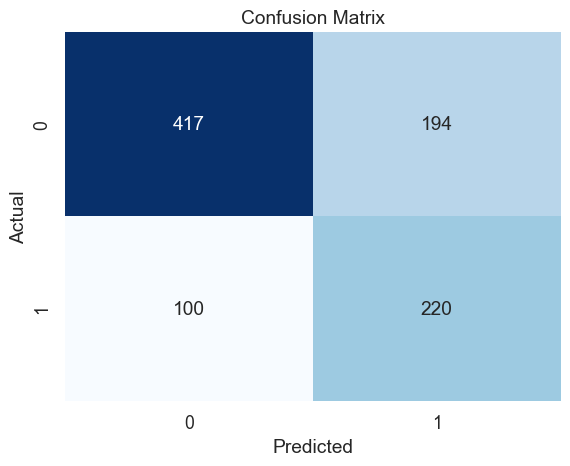

In [51]:
# SMOTE
call_model(clf_logistic, x_train_resampled, y_train_resampled, x_test, y_test)

{'auc': 0.7213456423895255,
 'f1-score': 0.45857418111753373,
 'precision': 0.5979899497487438,
 'recall': 0.371875,
 'support': 320.0}


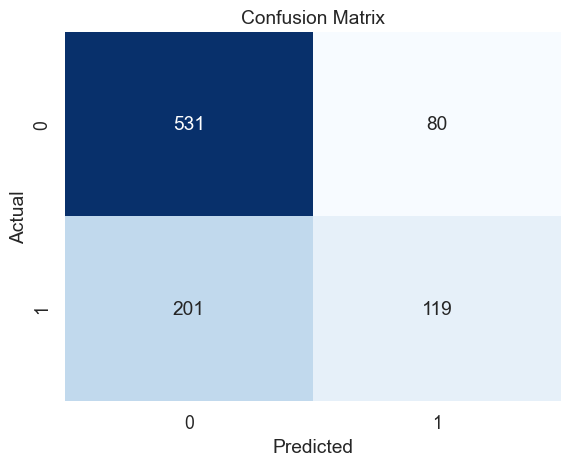

In [52]:
# Non-SMOTE
call_model(clf_logistic, x_train, y_train, x_test, y_test)

In [53]:
features = data.columns[:-1]
coefficients = clf_logistic.coef_

for feature, coef in zip(features, coefficients[0]):
    print(f"{feature}: {coef}")

Education: 0.20890779825982544
JoiningYear: 0.3344054746375382
City: 0.2831220634218463
PaymentTier: 0.2698753493632768
Age: -0.13209732919247955
Gender: 0.40196325904737445
EverBenched: 0.17806667083268485
ExperienceInCurrentDomain: -0.056453309776973375


### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier 

clf_dtree = DecisionTreeClassifier(random_state = seed)

{'auc': 0.7868836947626842,
 'f1-score': 0.6869009584664537,
 'precision': 0.7026143790849673,
 'recall': 0.671875,
 'support': 320.0}


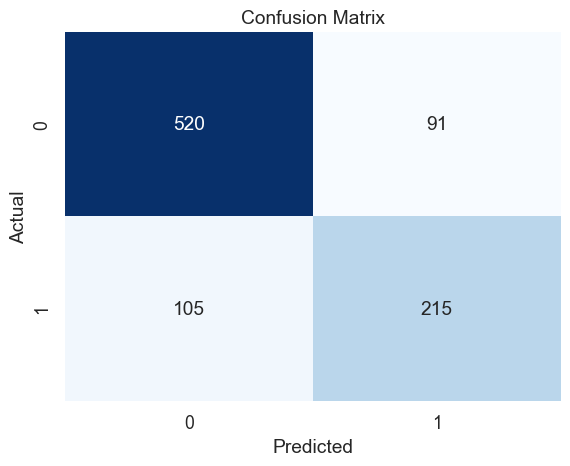

In [55]:
# SMOTE
call_model(clf_dtree, x_train_resampled, y_train_resampled, x_test, y_test)

{'auc': 0.7910929828150574,
 'f1-score': 0.6993464052287581,
 'precision': 0.7328767123287672,
 'recall': 0.66875,
 'support': 320.0}


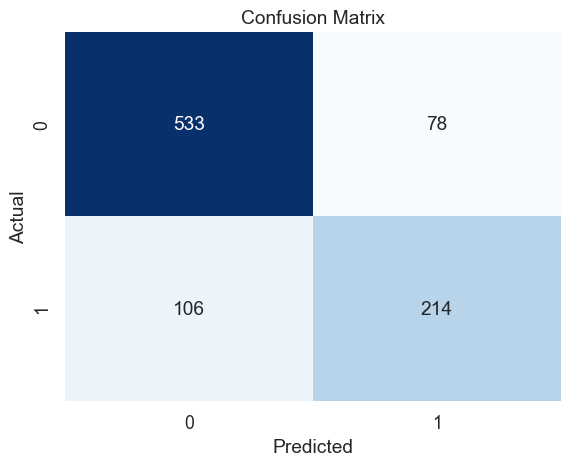

In [56]:
# Non-SMOTE
call_model(clf_dtree, x_train, y_train, x_test, y_test)

In [57]:
param_grid = {'max_depth': range(1, 11), 'min_samples_split': range(2, 11), 'min_samples_leaf': range(1, 6), 'max_features': range(2, 9)}

Grid_Search(clf_dtree, param_grid, x_train, y_train)

{'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}


{'auc': 0.8630856178396071,
 'f1-score': 0.7482758620689656,
 'precision': 0.8346153846153846,
 'recall': 0.678125,
 'support': 320.0}


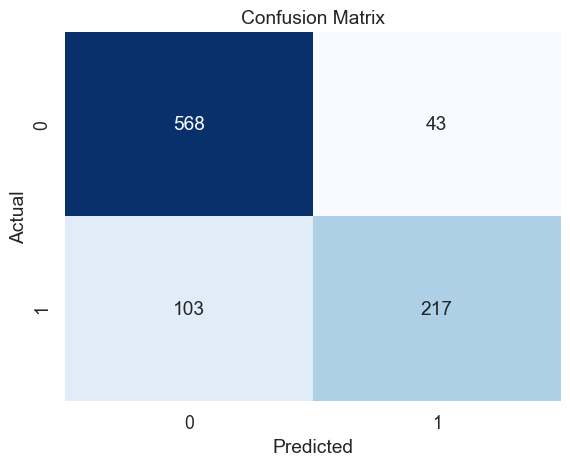

In [58]:
clf_dtree = DecisionTreeClassifier(random_state = seed, max_depth = 8, max_features = 8, min_samples_leaf = 5, min_samples_split = 2)

call_model(clf_dtree, x_train, y_train, x_test, y_test)

In [59]:
# 獲取特徵重要性
feature_importance = clf_dtree.feature_importances_

# 將特徵名稱與其重要性配對並排序
feature_importance_dict = dict(zip(data.columns[:-1], feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 顯示特徵重要性
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

JoiningYear: 0.3694371835151089
PaymentTier: 0.22506393415639547
City: 0.13528287772401948
Education: 0.10534043518528949
Age: 0.06287472741321691
Gender: 0.050535517564261785
ExperienceInCurrentDomain: 0.0359472863913551
EverBenched: 0.015518038050352904


### Knn

In [60]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=9)

{'auc': 0.832556771685761,
 'f1-score': 0.6853932584269663,
 'precision': 0.6224489795918368,
 'recall': 0.7625,
 'support': 320.0}


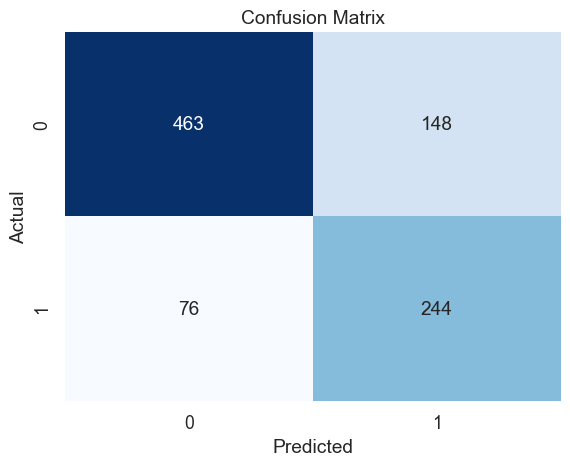

In [61]:
# SMOTE
call_model(clf_knn, x_train_resampled, y_train_resampled, x_test, y_test)

{'auc': 0.8344184738134206,
 'f1-score': 0.6976744186046512,
 'precision': 0.8158995815899581,
 'recall': 0.609375,
 'support': 320.0}


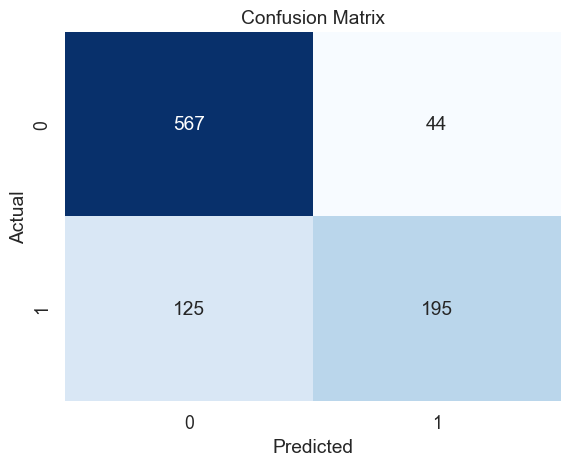

In [62]:
# Non-SMOTE
call_model(clf_knn, x_train, y_train, x_test, y_test)

In [63]:
# 設置參數網格
param_grid = {'n_neighbors': range(1, 11)}

# 使用GridSearchCV進行交叉驗證
grid_search = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

# 獲取最佳的 n_neighbors 值
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

Best n_neighbors: 9


{'auc': 0.8344184738134206,
 'f1-score': 0.6976744186046512,
 'precision': 0.8158995815899581,
 'recall': 0.609375,
 'support': 320.0}


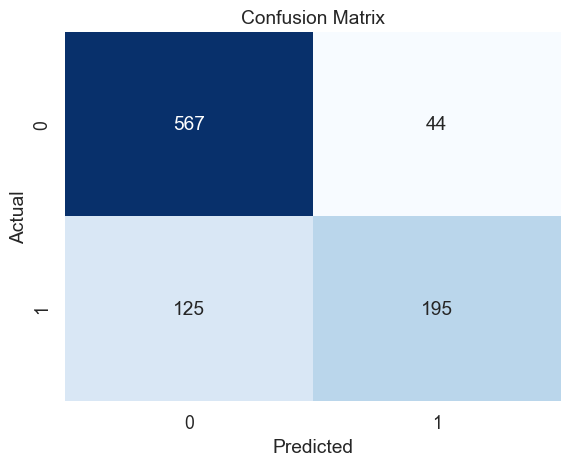

In [64]:
clf_knn = KNeighborsClassifier(n_neighbors=9)

# Non-SMOTE
call_model(clf_knn, x_train, y_train, x_test, y_test)

### SHAP Explainer

對 xgboost, SVM 模型進行 SHAP 值解釋。

c:\Users\Chi\anaconda3\envs\BI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


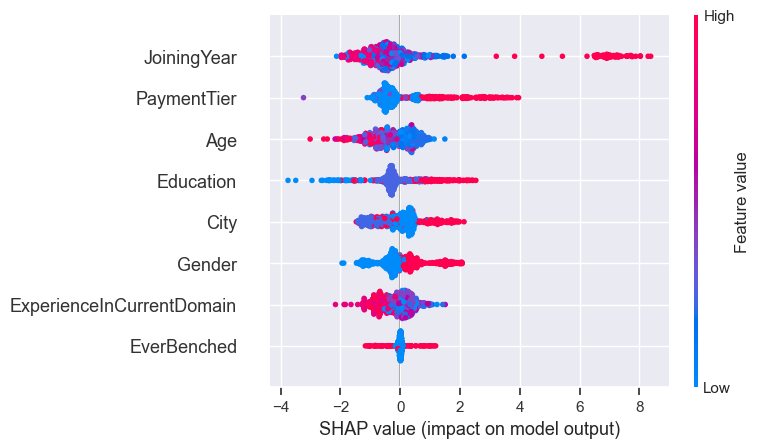

In [66]:
import shap

x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_test_copy = pd.DataFrame(x_test, columns = data.columns[:-1])

shap.initjs()

# 創建 SHAP 解釋器
explainer = shap.TreeExplainer(clf_xgb)
# 計算 SHAP 值
shap_values = explainer(x_test_copy)

shap.summary_plot(shap_values, x_test_copy)

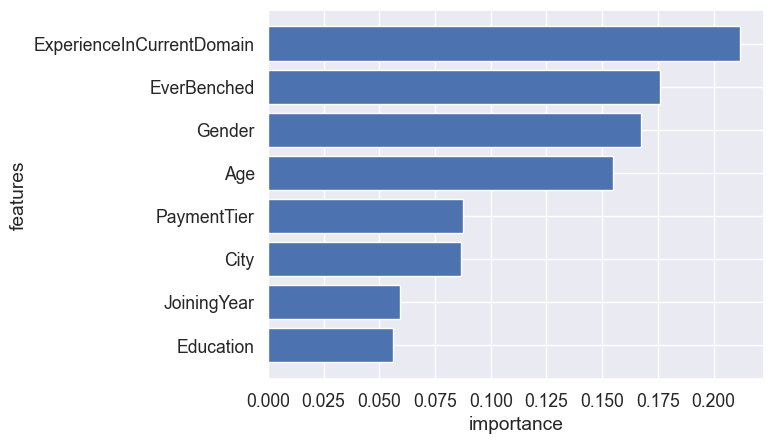

In [67]:
def plot_feature_importances(model):
      n_features = x.shape[1]
      sort_idx = model.feature_importances_.argsort()
      plt.barh(x_train_copy.columns[sort_idx],model.feature_importances_[sort_idx], align="center")
      plt.yticks(np.arange(n_features),x)
      plt.xlabel("importance")
      plt.ylabel("features")
      plt.show
plot_feature_importances(clf_xgb)